# SCVI plotting ACE2 and TMPRSS2 expression

In [14]:
import glob
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20


%matplotlib inline
plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
# Important constants we will use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 0
gene_threshold = 3

mito_criteria = 3.5

n_top_genes = 6000

n_bins = 20

flavor="seurat"

In [3]:
data = anndata.read_h5ad("write/data.h5ad")

In [4]:
data

AnnData object with n_obs × n_vars = 29045 × 9732 
    obs: 'SRR', 'age', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'leiden', 'louvain'
    var: 'gene_id', 'gene_counts', 'min_cells', 'pass_gene_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scale'

# SCVI Data

In [5]:
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE

from scvi.dataset import GeneExpressionDataset


In [6]:
data.var["top_n"] = data.var.index.isin(data.var["gene_counts"].nlargest(4000).index.values)

In [7]:
data.obs["batch"] = data.obs["SRR"]
data.obs["batch_idx"] = data.obs["SRR"].cat.codes.values

In [8]:
cells_dataset = GeneExpressionDataset()
cells_dataset.populate_from_data(
    data.layers["raw"],
    batch_indices=data.obs['batch_idx'],
    gene_names=data.var.index.values
)

[2020-04-01 22:00:48,019] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-01 22:00:48,021] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


In [9]:
cells_dataset.filter_genes_by_count(per_batch=True)
cells_dataset.subsample_genes(6000)

[2020-04-01 22:00:48,522] INFO - scvi.dataset.dataset | Downsampling from 9732 to 9723 genes
[2020-04-01 22:00:48,716] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-01 22:00:48,746] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-01 22:00:48,907] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-01 22:00:48,936] INFO - scvi.dataset.dataset | Downsampled from 29045 to 29045 cells
[2020-04-01 22:00:48,936] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-04-01 22:01:01,231] INFO - scvi.dataset.dataset | Downsampling from 9723 to 6000 genes
[2020-04-01 22:01:01,409] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-01 22:01:01,435] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-01 22:01:01,540] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-01 22:01:01,564] INFO - scvi.dataset.dataset | Downsampled from 29045 to 29045 cells


In [10]:
cells_dataset

GeneExpressionDataset object with n_cells x nb_genes = 29045 x 6000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_means', 'batch_indices', 'local_vars', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [11]:
n_latent = 10
vae = VAE(
    cells_dataset.nb_genes,
    n_batch=cells_dataset.n_batches,
    reconstruction_loss='nb',
    n_latent=n_latent
)

In [12]:
n_epochs = 3
lr = 1e-3
use_cuda = True


trainer = UnsupervisedTrainer(
    vae,
    cells_dataset,
    use_cuda=use_cuda,
    frequency=1,
    n_iter_kl_warmup=0,
)

In [13]:
%%time
trainer.train(n_epochs=n_epochs, lr=lr)

[2020-04-01 22:01:05,099] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.



[2020-04-01 22:01:46,658] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
CPU times: user 16min 57s, sys: 12min 8s, total: 29min 6s
Wall time: 45 s


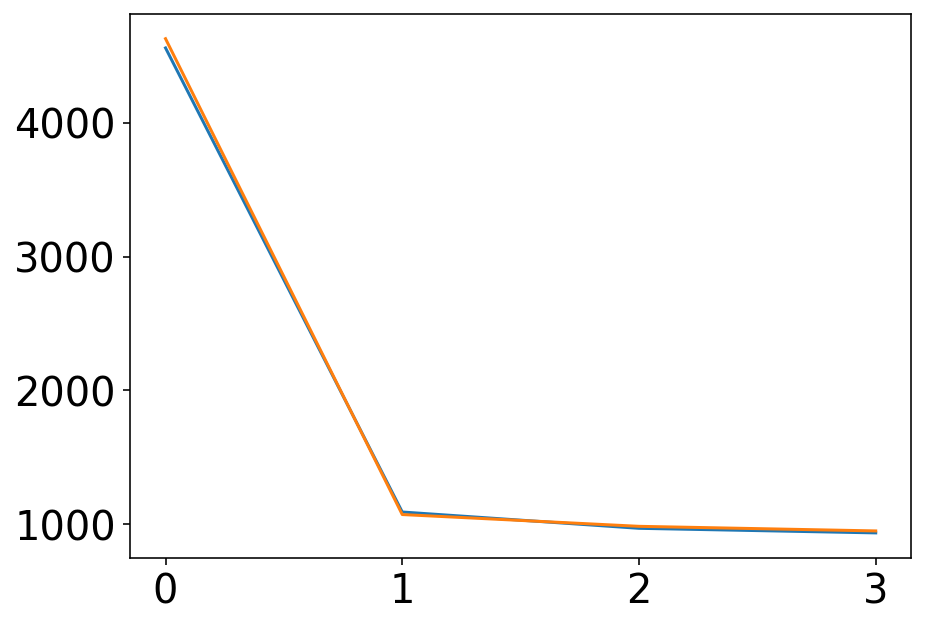

In [15]:
fig, ax = plt.subplots(figsize=(7,5))

y_train = trainer.history["elbo_train_set"]
y_test = trainer.history["elbo_test_set"]

x = np.arange(len(y_train))

ax.plot(x, y_train, label="train")
ax.plot(x, y_test, label="test")

plt.show()

In [16]:
full_posterior = trainer.create_posterior()
latent = full_posterior.get_latent()

# Put info back in data h5ad

In [17]:
data.obsm["z_scvi"] = latent[0]

In [18]:
for i, z in enumerate(data.obsm['z_scvi'].T):
    data.obs[f'z_{i}'] = z

In [19]:
data.obsm["z_scvi"].shape

(29045, 10)

In [20]:
%%time
# TSNE
X = data.obsm["z_scvi"]

tsne = TSNE(n_components=2, metric="euclidean", random_state=42)
data.obsm["X_scvi_tsne"] = tsne.fit_transform(X)

CPU times: user 21min 59s, sys: 2min 33s, total: 24min 32s
Wall time: 1min 4s


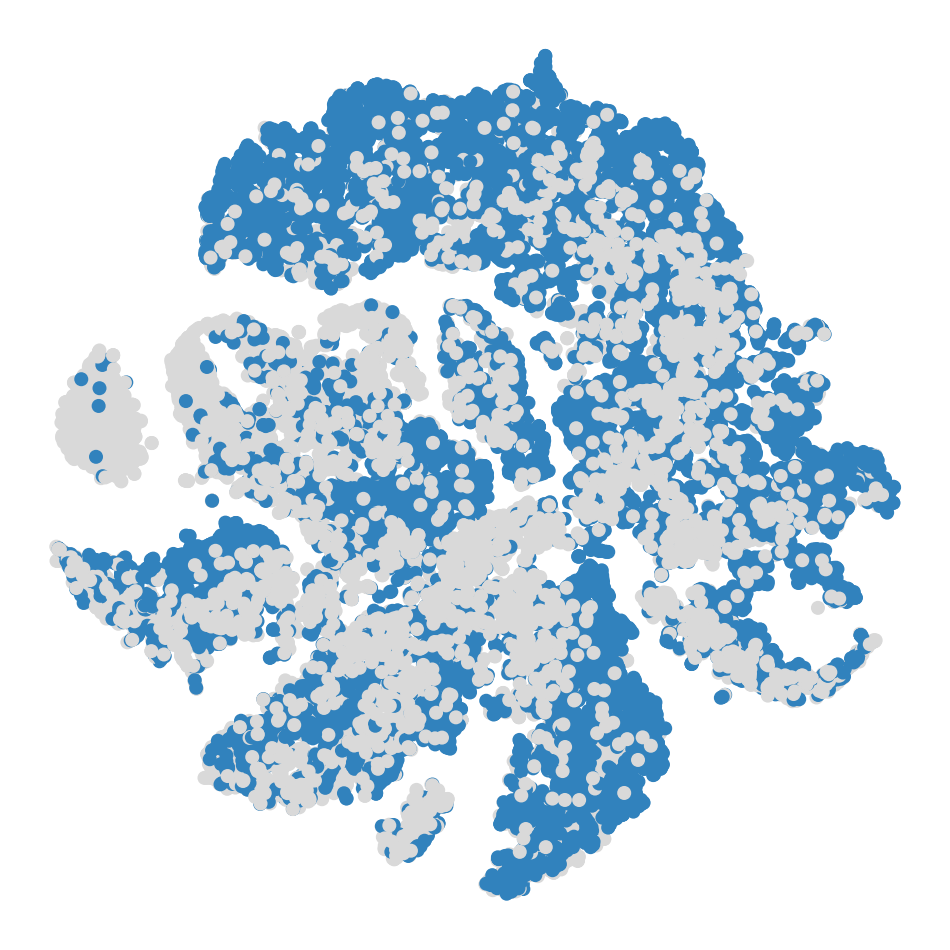

In [21]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_scvi_tsne"][:,0]
y = data.obsm["X_scvi_tsne"][:,1]
c = data.obs["age"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20c', alpha=1)

ax.set_axis_off()

plt.tight_layout()
plt.show()

# Plot ACE2 and TMPRSS2

In [22]:
def get_xyc(data, gene):
    c = nd(data.layers["raw"].todense()[:,data.var.index.values==gene])
    x = data.obsm["X_scvi_tsne"][:,0]
    y = data.obsm["X_scvi_tsne"][:,1]
    return (x ,y, c)

In [23]:
def fix_xyc(x,y,c, mask):
    c_f = c[mask]
    argsort = np.argsort(c_f)
    c_f = c_f[argsort]
    x_f = x[mask][argsort]
    y_f = y[mask][argsort]
    
    return (x_f, y_f, c_f)

In [24]:
young_m = nd(data.obs.age.values==3)
old_m =   nd(data.obs.age.values==24)

In [25]:
gene = "Tmprss2"
tmprss2 = get_xyc(data, gene)

gene = "Ace2"
ace2 = get_xyc(data, gene)

Pass stacked C to Reds and Blues
mask the result by old v young and that is the vector c

In [26]:
def plot_old_young(x,y,c, ax):
    cmask = c>0
    c = c/c.max()
    x = x
    y = y
    
    young_mask = young_m
    old_mask = old_m
    
    r = cm.Reds(c)
    b = cm.Blues(c)
    
    cc = np.zeros((len(c), 4))
    
    cc[young_mask] = r[young_mask,:]
    cc[old_mask] = b[old_mask,:]
    
    argsort = np.argsort(c)
    
    xx = x[argsort]
    yy = y[argsort]
    cc = cc[argsort]
    
    ax.scatter(xx, yy,c=cc, alpha=1)
    return ax


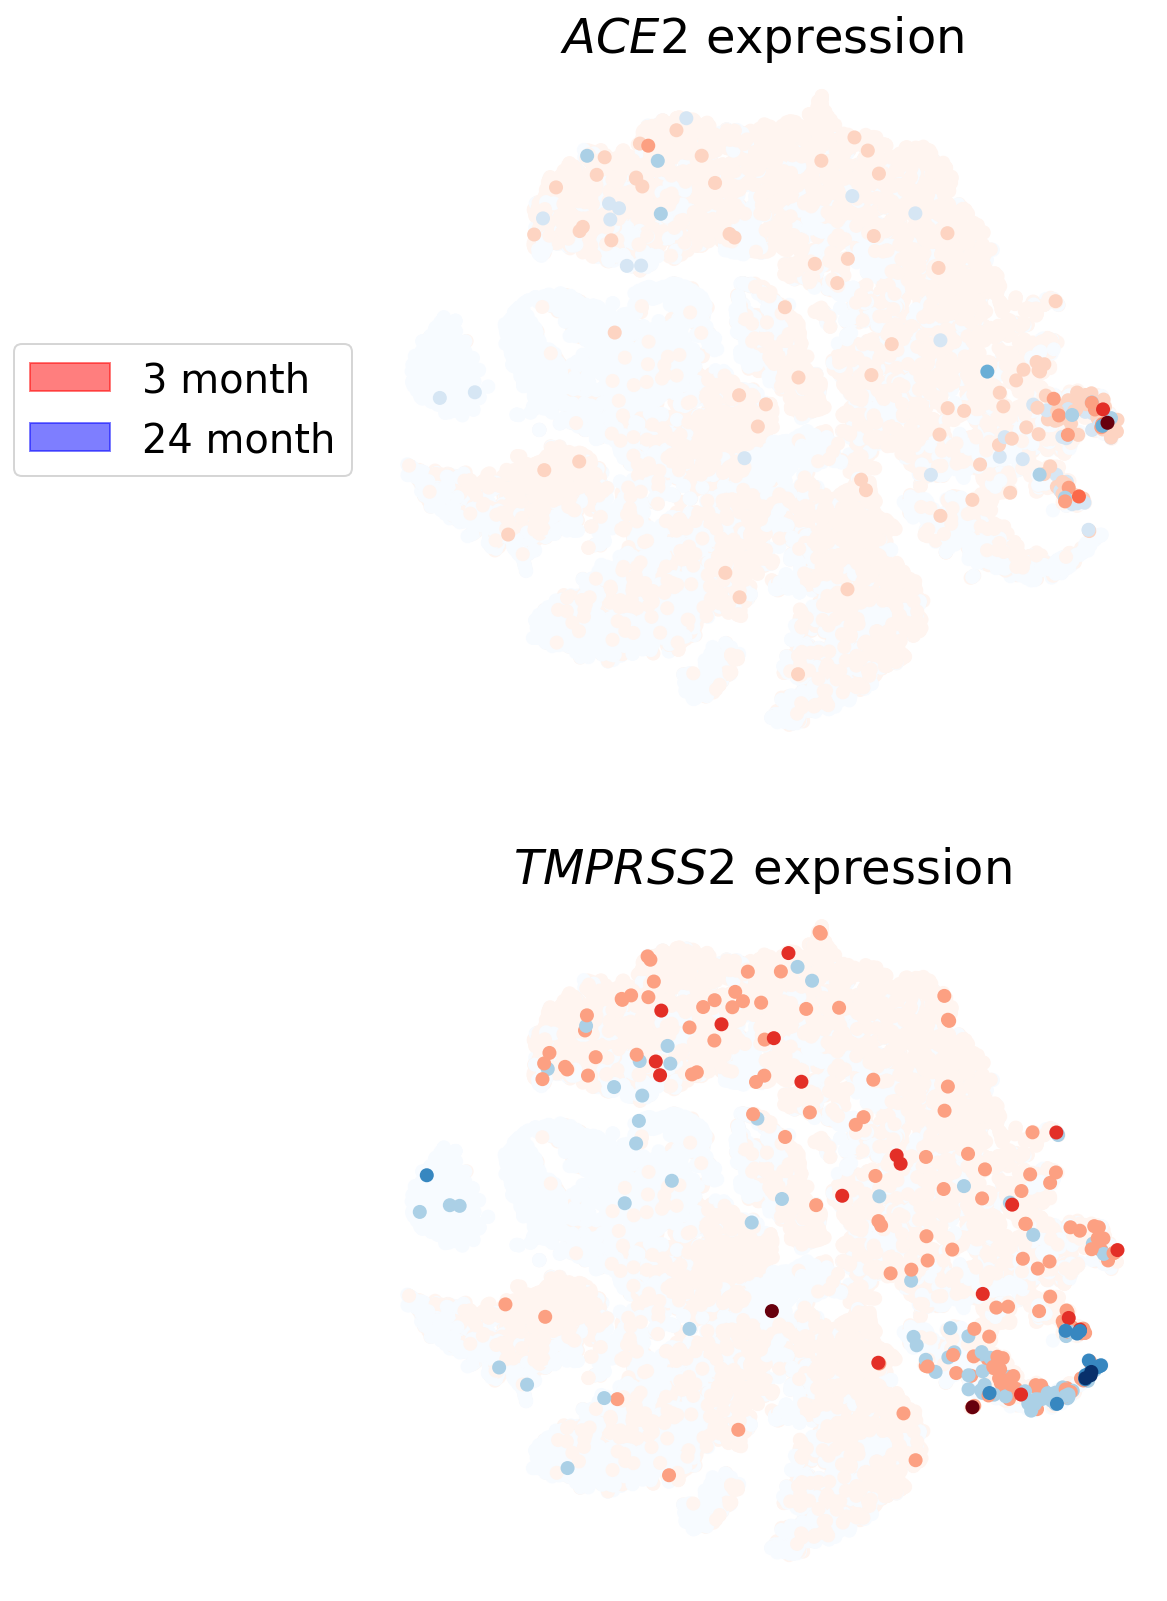

In [27]:
fig, ax = plt.subplots(figsize=(7,14), nrows=2)


gene = "Ace2"
x,y,c = ace2
plot_old_young(x,y,c,ax[0])
ax[0].set_axis_off()
ax[0].set_title("$ACE2$ expression".format(gene))

gene = "Tmprss2"
x,y,c = tmprss2
plot_old_young(x,y,c,ax[1])
ax[1].set_axis_off()
ax[1].set_title("$TMPRSS2$ expression".format(gene))


red = mpatches.Patch(color='red', label='3 month', alpha=0.5)
blue = mpatches.Patch(color='blue', label='24 month', alpha=0.5)
ax[0].legend(bbox_to_anchor=(0, 0.5), loc="center right", handles=[red, blue])

plt.savefig("./figs/scvi_ace2_tmprss_old_young.png", bbox_inches='tight',dpi=300)

#plt.tight_layout()
plt.show()

In [28]:
data.write("write/data_scvi.h5ad")

In [40]:
gidx = np.where(data.var.index.values=="Ace2")[0][0]

In [41]:
data.var.index.values[gidx]

'Ace2'

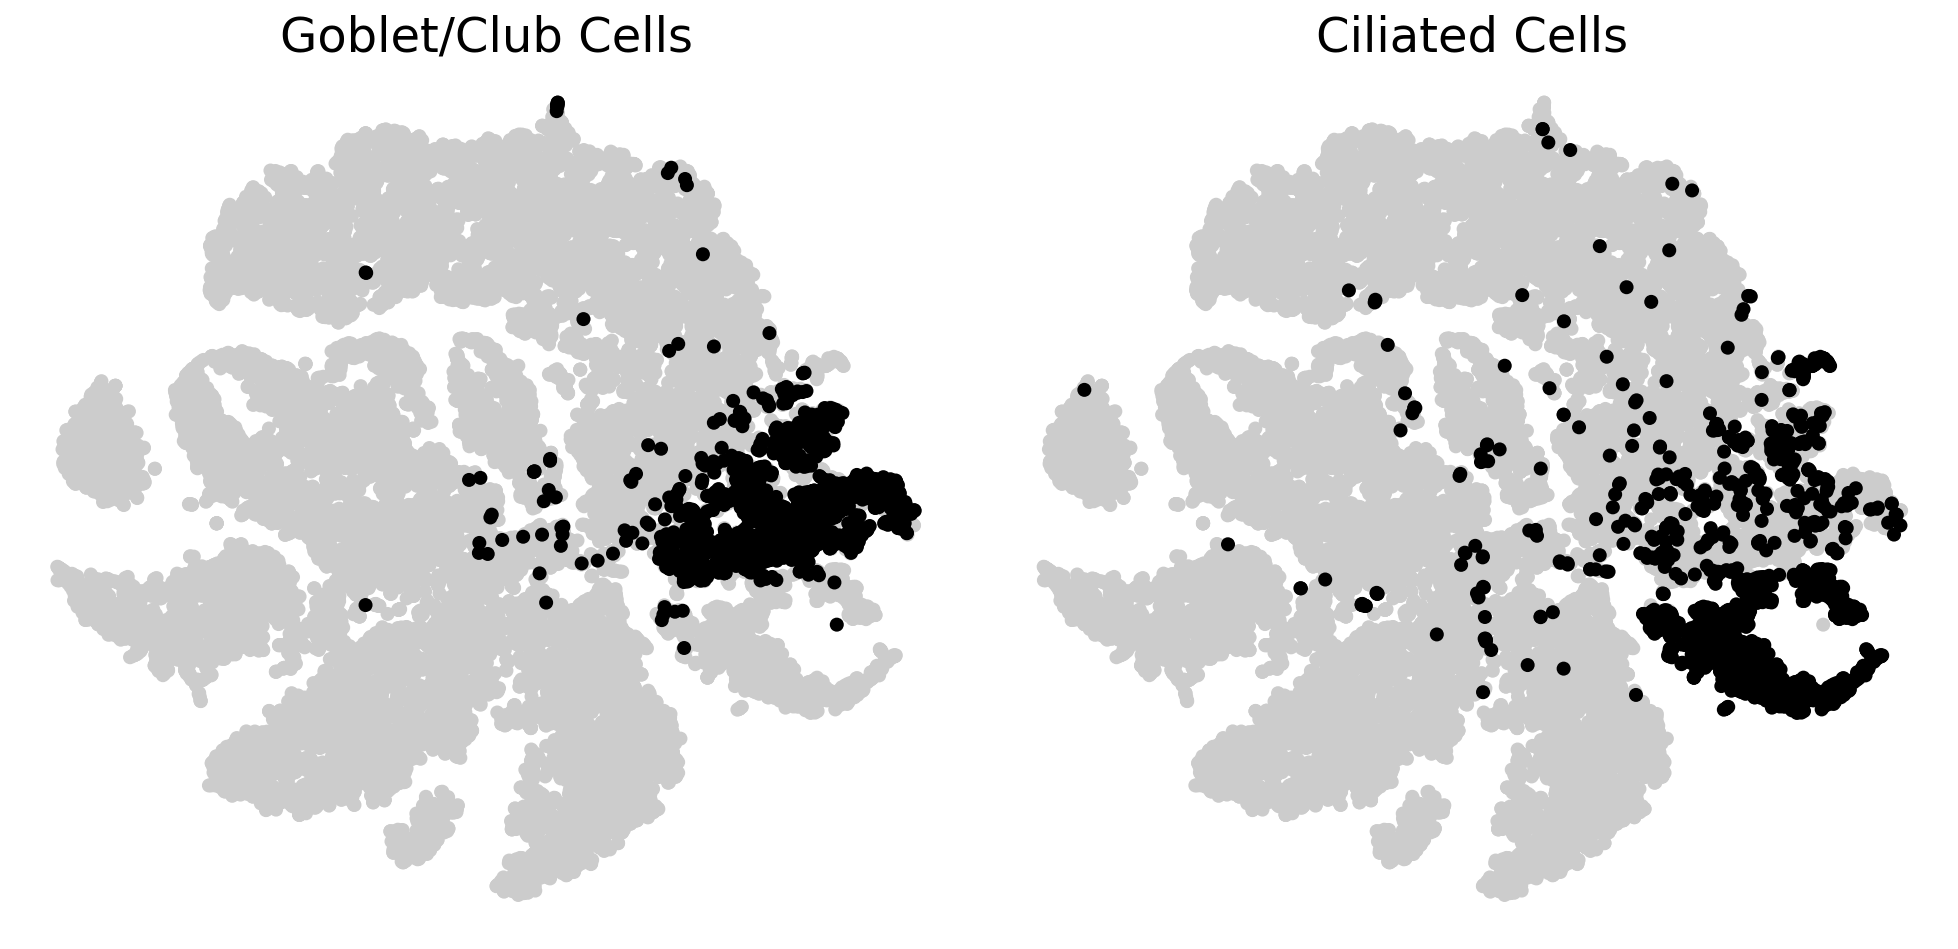

In [81]:
fig, ax = plt.subplots(figsize=(14,7), ncols=2)

c = data.obs["leiden"].astype(int)==5
argsort = np.argsort(c)
c = c[argsort]
x = data.obsm["X_scvi_tsne"][:,0][argsort]
y = data.obsm["X_scvi_tsne"][:,1][argsort]


ax[0].scatter(x, y, c = c, cmap='nipy_spectral_r', alpha=1)
ax[0].set_title("Goblet/Club Cells")
ax[0].set_axis_off()

c = data.obs["leiden"].astype(int)==4
argsort = np.argsort(c)
c = c[argsort]
x = data.obsm["X_scvi_tsne"][:,0][argsort]
y = data.obsm["X_scvi_tsne"][:,1][argsort]

ax[1].scatter(x, y, c = c, cmap='nipy_spectral_r', alpha=1)
ax[1].set_title("Ciliated Cells")
ax[1].set_axis_off()

plt.savefig("./figs/goblet_club_ciliated_loc.png", bbox_inches='tight',dpi=300)


plt.tight_layout()
plt.show()